# ASR with Tensorflow 

In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
DATASET_PATH = "data/"
data_dir = pathlib.Path(DATASET_PATH)

if not data_dir.exists():

    tf.keras.utils.get_file(
    'speech_commands_v0.02.tar.gz',  
origin="http://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
extract=True,
cache_dir='.', cache_subdir='data')

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['right' 'eight' 'cat' 'tree' 'backward' 'learn' 'bed' 'happy' 'go'
 'validation_list.txt' 'LICENSE' 'dog' 'no' 'wow' 'follow' 'nine' 'left'
 'stop' 'three' '_background_noise_' 'sheila' 'one' 'bird' 'zero' 'seven'
 'up' 'visual' 'speech_commands_v0.02.tar.gz' 'marvin' 'two' 'house'
 'down' 'six' 'yes' 'on' 'testing_list.txt' 'five' 'forward' 'off' 'four']


In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
directory=data_dir,
batch_size=64,
validation_split=0.2,
seed=0,
output_sequence_length=16000,
subset='both')
label_names = np.array(train_ds.class_names)
print("label names:", label_names)

Found 105835 files belonging to 36 classes.
Using 84668 files for training.
Using 21167 files for validation.
label names: ['_background_noise_' 'backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight'
 'five' 'follow' 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left'
 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six'
 'stop' 'three' 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


### Adjusting axes

In [5]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze,tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze,tf.data.AUTOTUNE)

### Test/Validation split

In [6]:
for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

train_ds = val_ds.shard(num_shards=3,index=0)
test_ds = val_ds.shard(num_shards=3,index=1)
val_ds = val_ds.shard(num_shards=3,index=2)

(64, 16000)
(64,)


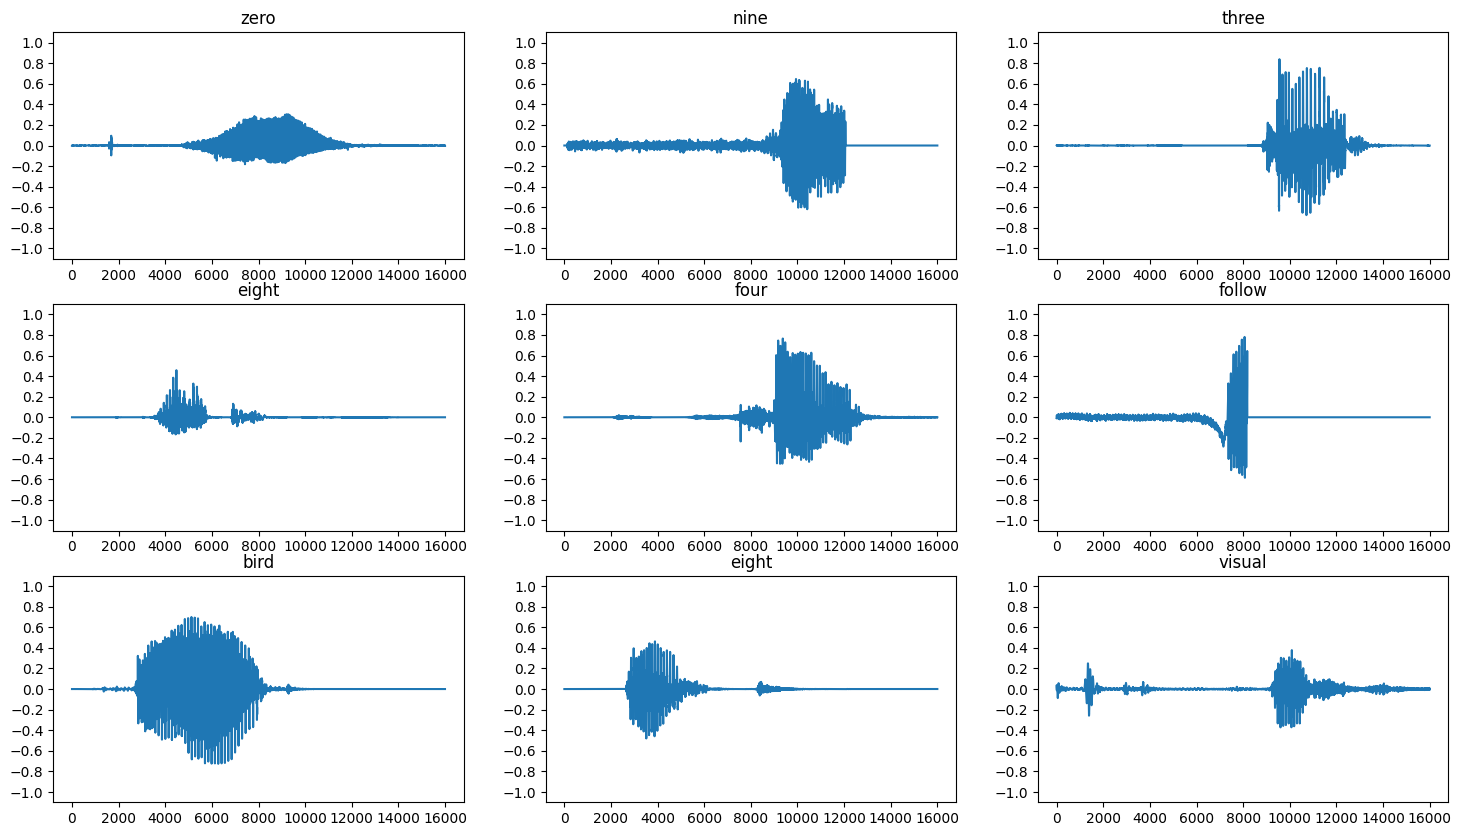

In [7]:
n = 9
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
for i in range(n):
    if i>=n:
        break
    r = i // 3
    c = i % 3
    ax = axes[r][c]
    ax.plot(example_audio[i].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2,0.2))
    label =label_names[example_labels[i]]
    ax.set_title(label)
    ax.set_ylim([-1.1,1.1])
plt.show()

You can see that for different words the shape of the wave differs, which is expected because different letters are pronounced differently, which results in a different audio wave.

### Spectrogram calculation

In [8]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform,frame_length=255,frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[...,tf.newaxis]
    return spectrogram

### Spectrogram visualization

In [9]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

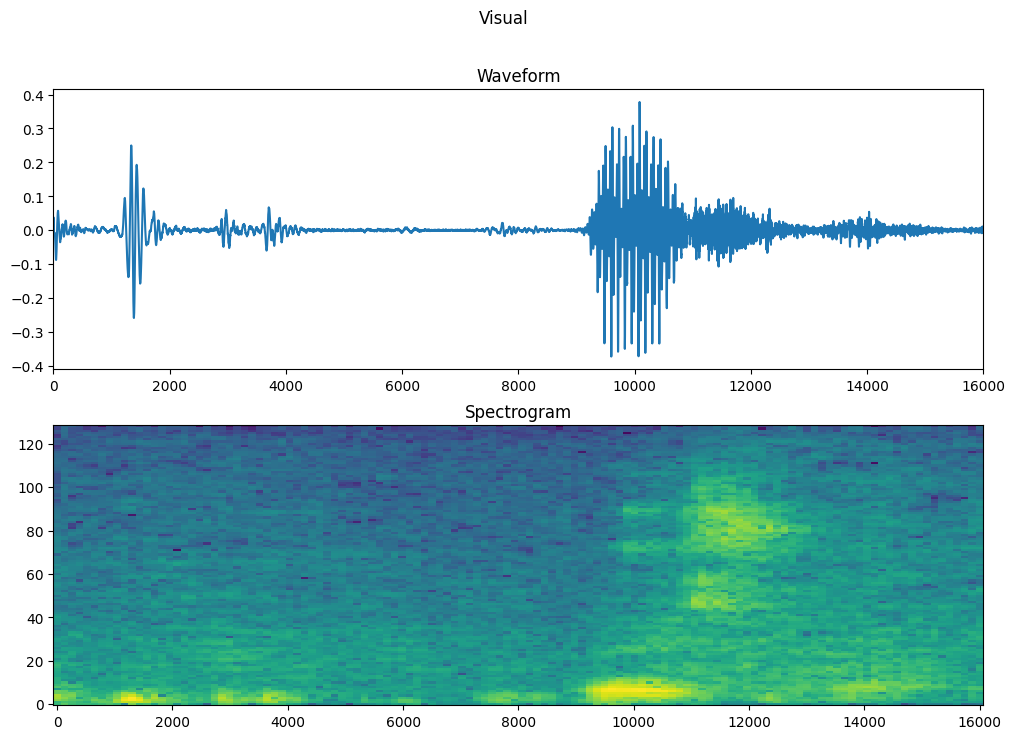

In [10]:
waveform = example_audio[i]
spectrogram = get_spectrogram(waveform)
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

### Creating Spectrogram datasets

In [11]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio,label: 
(get_spectrogram(audio),label),num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds=make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

### Reducing read latency

In [12]:
train_spectrogram_ds=train_spectrogram_ds.cache().shuffle(64).prefetch(tf.data.AUTOTUNE)


val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### Adjusting input shape

In [13]:
example_spectrograms,example_spect_labels = get_spectrogram(example_audio), example_labels
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

Input shape: (124, 129, 1)


### Model Building

In [14]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    layers.Normalization(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

### Plotting the model components

In [15]:
tf.keras.utils.plot_model(model, to_file="my_model.png",show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Preparing model for training 

In [16]:
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])

### Training the model


In [17]:
history = model.fit(
train_spectrogram_ds,
validation_data=val_spectrogram_ds,
epochs=8,callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/8
111/111 [==============================] - 5s 30ms/step - loss: 3.4392 - accuracy: 0.1098 - val_loss: 2.8977 - val_accuracy: 0.2277
Epoch 2/8
111/111 [==============================] - 3s 23ms/step - loss: 3.2746 - accuracy: 0.2337 - val_loss: 2.8197 - val_accuracy: 0.2973
Epoch 3/8
111/111 [==============================] - 3s 23ms/step - loss: 4.3999 - accuracy: 0.3132 - val_loss: 4.8928 - val_accuracy: 0.3284
Epoch 4/8
111/111 [==============================] - 3s 23ms/step - loss: 7.1657 - accuracy: 0.3591 - val_loss: 9.8858 - val_accuracy: 0.3061
Epoch 4: early stopping


In [19]:
model = tf.keras.models.load_model('saved_model/')

### Plotting learning curves


Text(0, 0.5, 'Accuracy [%]')

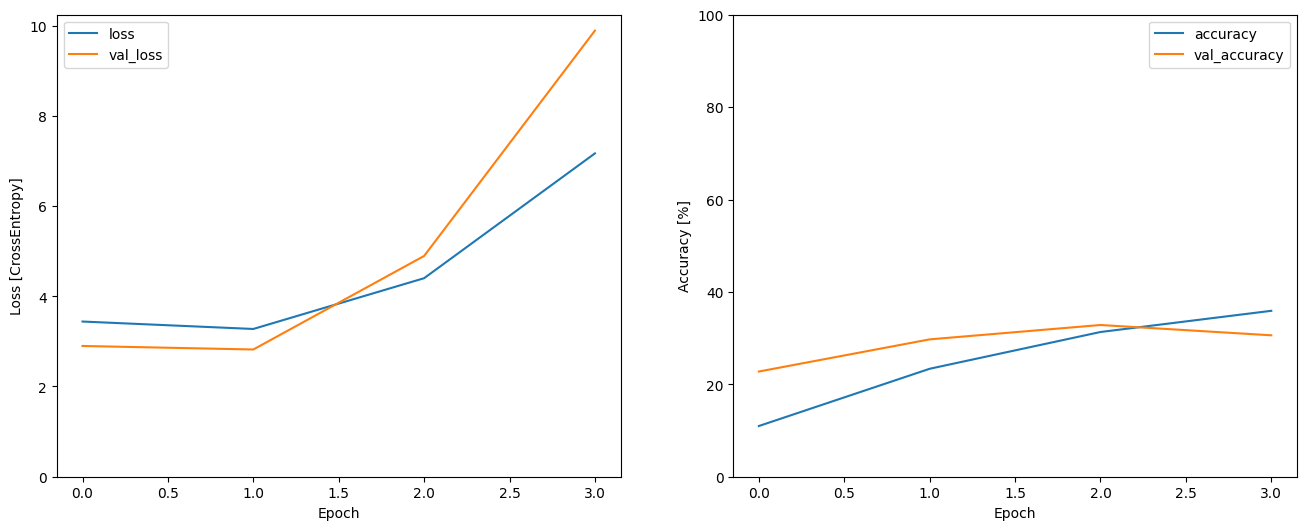

In [20]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, 
metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluating the model performance

In [21]:
model.evaluate(test_spectrogram_ds,return_dict=True)

110/110 [==============================] - 2s 14ms/step - loss: 6.5090 - accuracy: 0.4094


{'loss': 6.5090250968933105, 'accuracy': 0.40937501192092896}

### Plot the confusion matrix

110/110 [==============================] - 1s 7ms/step


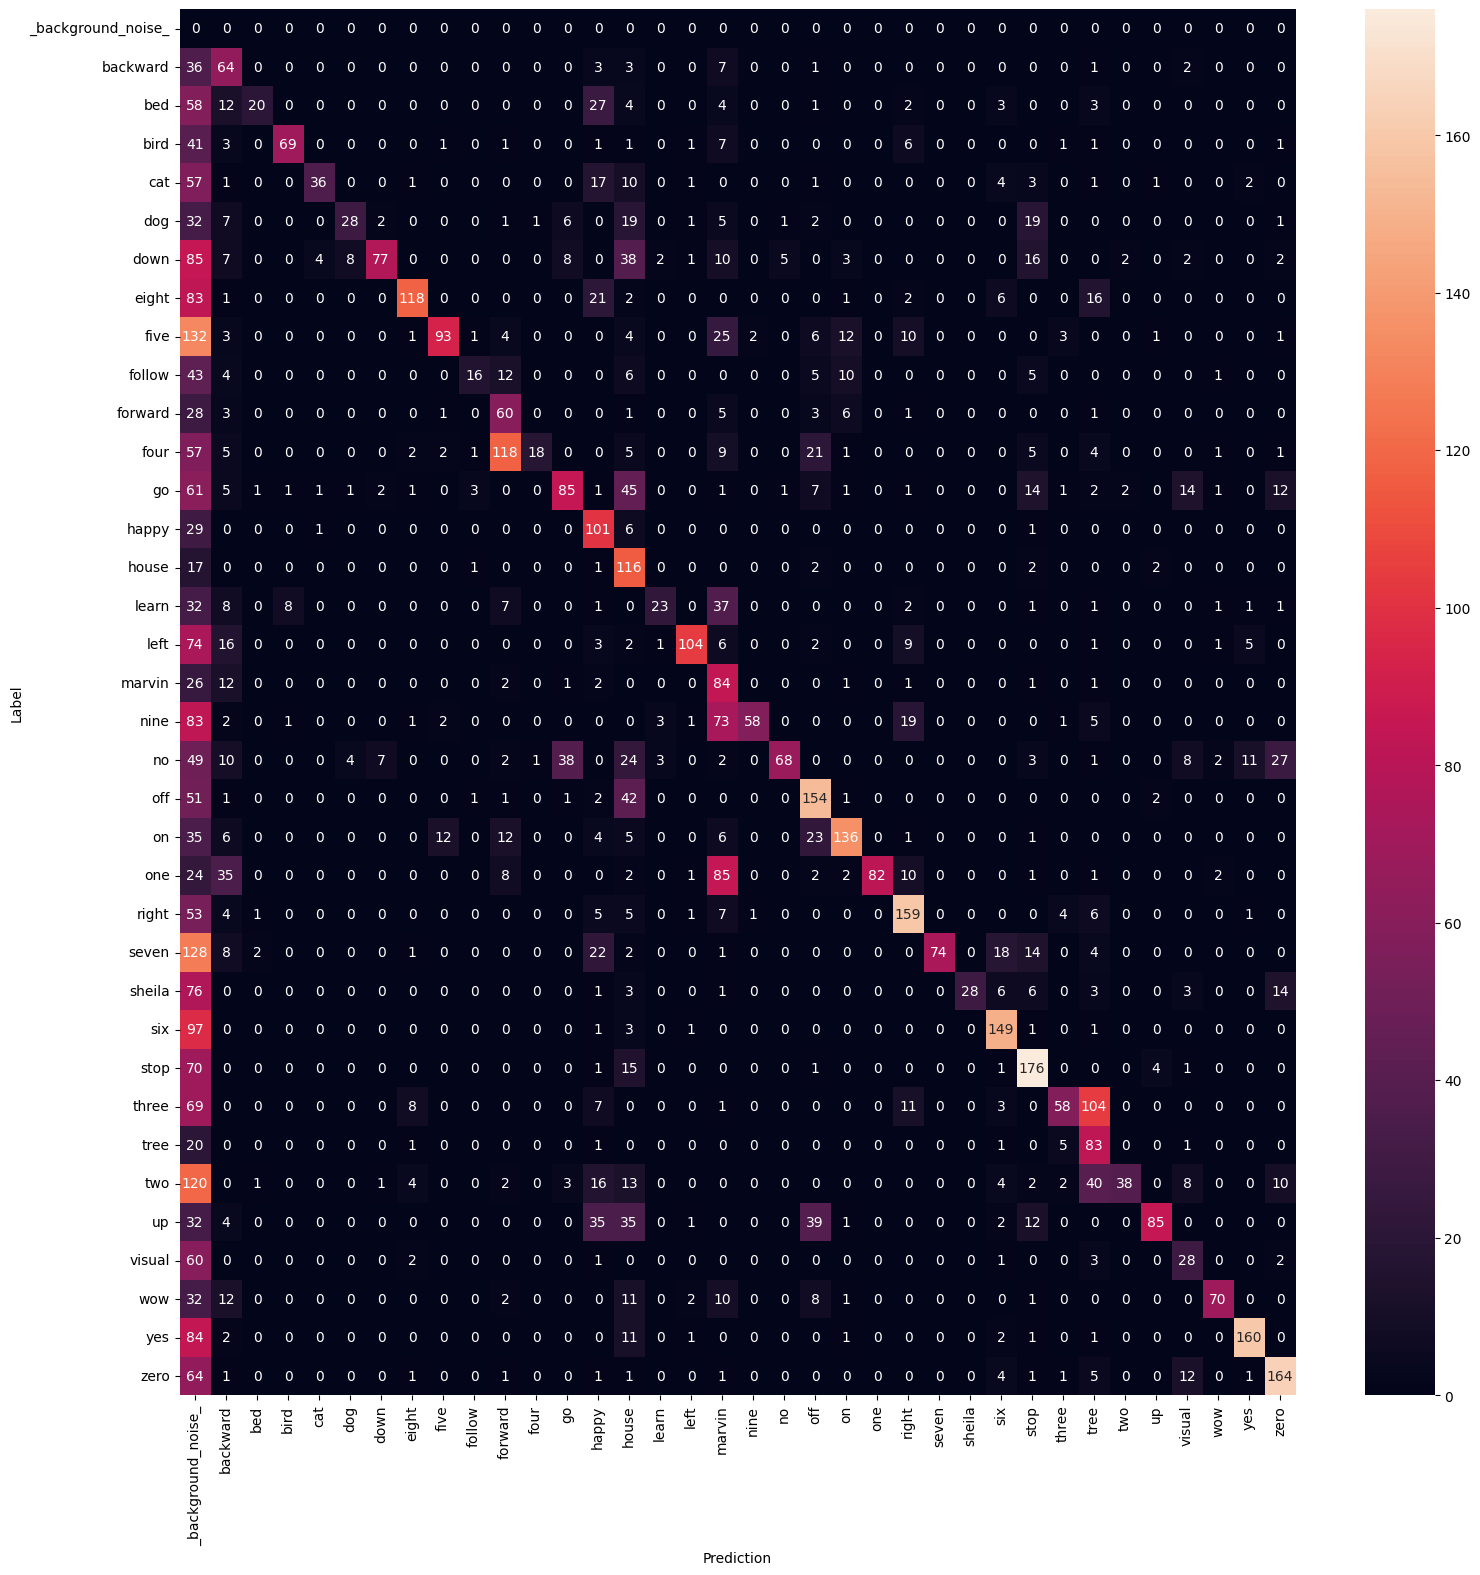

In [22]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(18, 18))
sns.heatmap(confusion_mtx,
        xticklabels=label_names,
        yticklabels=label_names,
        annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Setting the pre-processing function

In [23]:
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=(), dtype=tf.string))
        self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


    @tf.function
    def __call__(self, x):
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
            x = tf.squeeze(x, axis=-1)
            x = x[tf.newaxis, :]
        x = get_spectrogram(x)  
        result = self.model(x, training=False)
        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(label_names, class_ids)
        return {'predictions':result,
                'class_ids': class_ids,
                'class_names': class_names}

### Saving model

In [24]:
export = ExportModel(model)
tf.saved_model.save(export, "saved")

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets
